### Import Libraries

In [1]:
import os
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
Image.MAX_IMAGE_PIXELS = None

### Define dataset paths and categories

In [2]:
train_folder = r"C:\Users\ayush\Desktop\gagan\gagan\forestfire-classifier-dataset\train"
test_folder = r"C:\Users\ayush\Desktop\gagan\gagan\forestfire-classifier-dataset\test"
val_folder = r"C:\Users\ayush\Desktop\gagan\gagan\forestfire-classifier-dataset\val"

categories = ['fire', 'nofire', 'smoke']

### Count and Plot Image Distribution in Train Dataset

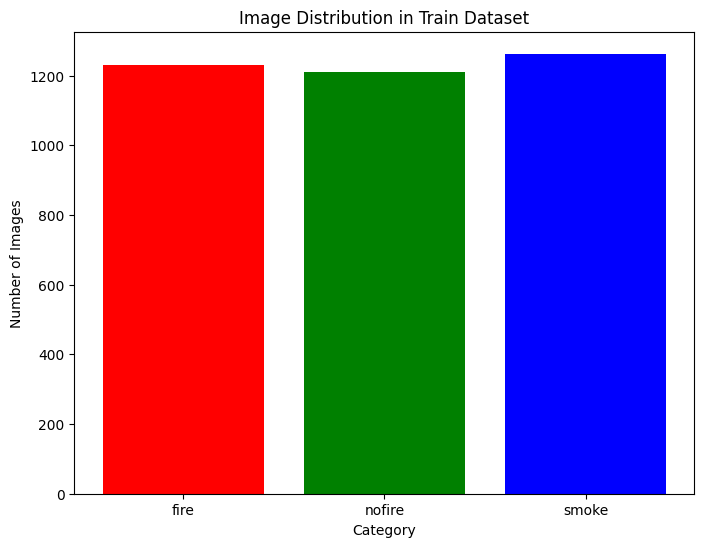

Image counts: [1231, 1211, 1263]


In [3]:
image_counts = []
for category in categories:
    category_path = os.path.join(train_folder, category)
    image_count = len(os.listdir(category_path))
    image_counts.append(image_count)

plt.figure(figsize=(8, 6))
plt.bar(categories, image_counts, color=['red', 'green', 'blue'])
plt.title('Image Distribution in Train Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

print(f"Image counts: {image_counts}")

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

images = []
labels = []

In [5]:
# Load and preprocess images from the train folder
for category in categories:
    category_path = os.path.join(train_folder, category)
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img_array = np.array(img, dtype=np.float32) / 255.0
        images.append(img_array)
        labels.append(category)

# Convert to numpy arrays
images = np.array(images, dtype=np.float32) 
labels = np.array(labels)

print(f"Loaded {len(images)} images.")
print(f"Images shape: {images.shape}")

Loaded 3705 images.
Images shape: (3705, 224, 224, 3)


### Encode labels to numerical values

In [6]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"Labels after encoding: {labels_encoded}")

Labels after encoding: [0 0 0 ... 2 2 2]


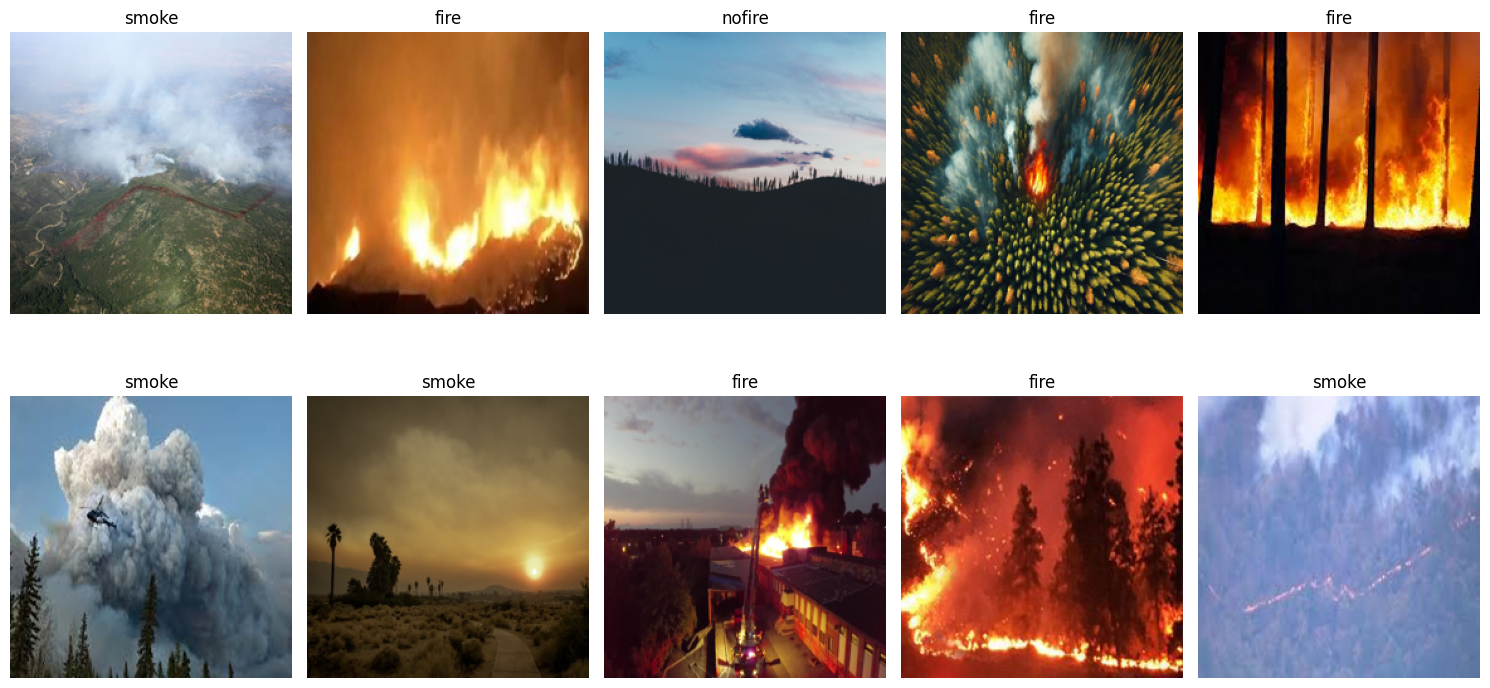

In [7]:
def plot_sample_images(images, labels, num_samples=10):
    plt.figure(figsize=(15, 8))
    random_indices = np.random.choice(len(images), num_samples, replace=False)
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        plt.title(label_encoder.inverse_transform([labels[idx]])[0])
    plt.tight_layout()
    plt.show()

plot_sample_images(images, labels_encoded)

In [8]:
# Create ImageDataGenerators for training, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,      # Rescale the pixel values to [0,1]
    rotation_range=20,      # Augmentation options
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # For test, only rescaling

# Generate batches of images from the train folder
train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse',     # Use 'sparse' because labels are integer encoded
    subset='training'
)

# Generate batches of validation images
validation_generator = val_datagen.flow_from_directory(
    directory=val_folder,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse'
)

# Test generator (no augmentation, just rescaling)
test_generator = test_datagen.flow_from_directory(
    directory=test_folder,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse'
)

Found 3705 images belonging to 3 classes.
Found 395 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), include_top=False, weights='imagenet')
print("MobileNetV2 loaded with pre-trained weights.")

def build_model(input_shape):
    base_model.trainable = False  # Freeze the base model
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(categories), activation='softmax')  # Output layer
    ])
    return model

model = build_model((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled.")


MobileNetV2 loaded with pre-trained weights.
Model compiled.


In [10]:
# Fit the model using the train and validation generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100
)

Epoch 1/100
116/116 [==============================] - 287s 2s/step - loss: 1.2485 - accuracy: 0.4842 - val_loss: 0.6714 - val_accuracy: 0.7367
Epoch 2/100
116/116 [==============================] - 266s 2s/step - loss: 0.8557 - accuracy: 0.6256 - val_loss: 0.5896 - val_accuracy: 0.7671
Epoch 3/100
116/116 [==============================] - 266s 2s/step - loss: 0.7460 - accuracy: 0.6858 - val_loss: 0.5449 - val_accuracy: 0.7848
Epoch 4/100
116/116 [==============================] - 268s 2s/step - loss: 0.6564 - accuracy: 0.7379 - val_loss: 0.5311 - val_accuracy: 0.7848
Epoch 5/100
116/116 [==============================] - 267s 2s/step - loss: 0.6224 - accuracy: 0.7503 - val_loss: 0.5211 - val_accuracy: 0.7747
Epoch 6/100
116/116 [==============================] - 267s 2s/step - loss: 0.6199 - accuracy: 0.7541 - val_loss: 0.5202 - val_accuracy: 0.7696
Epoch 7/100
116/116 [==============================] - 269s 2s/step - loss: 0.5978 - accuracy: 0.7525 - val_loss: 0.5312 - val_accuracy:

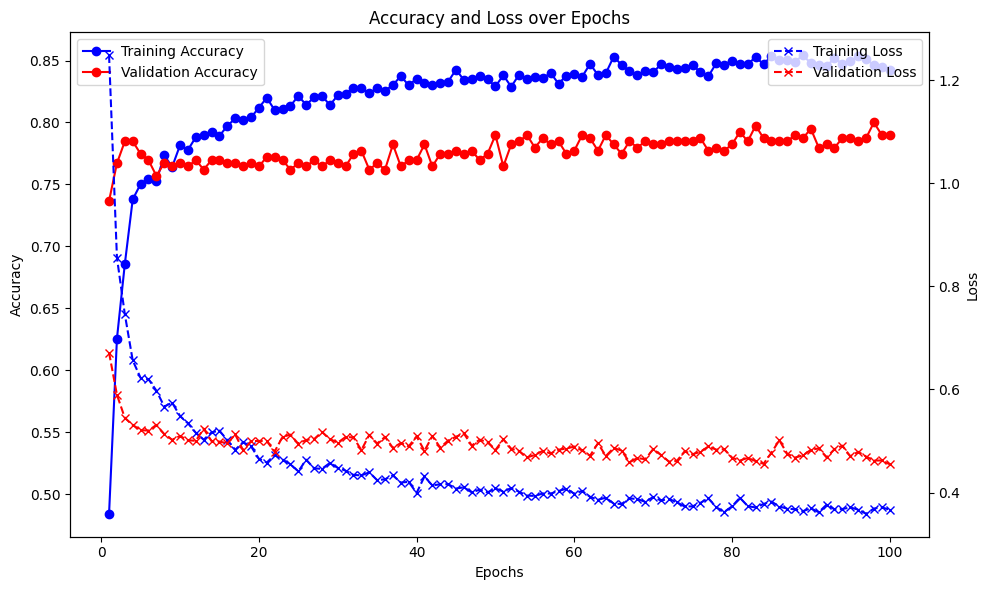

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

# Create subplots for accuracy and loss
fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy plot
ax1.plot(epochs, accuracy, 'b-', label='Training Accuracy', marker='o')
ax1.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy and Loss over Epochs')
ax1.legend(loc='upper left')

# Loss plot on the same figure with a different axis
ax2 = ax1.twinx()
ax2.plot(epochs, loss, 'b--', label='Training Loss', marker='x')
ax2.plot(epochs, val_loss, 'r--', label='Validation Loss', marker='x')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

In [12]:
# Save the trained model
model.save('forest_fire_classification_model.h5')

In [13]:
# Load the saved model
saved_model = tf.keras.models.load_model('forest_fire_classification_model.h5')

# Now you can evaluate or make predictions using the saved model
test_loss, test_accuracy = saved_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions using the saved model
predictions = saved_model.predict(test_generator)

13/13 [==============================] - 35s 3s/step - loss: 0.4065 - accuracy: 0.8395
Test Loss: 0.4065
Test Accuracy: 0.8395
13/13 [==============================] - 34s 3s/step


In [14]:
# Load the trained model from the saved .h5 file
# saved_model = load_model('forest_fire_classification_model.h5')

# Reset the test generator to start from the first batch
test_generator.reset()

# Use the loaded model to make predictions on the test set
predictions = saved_model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

13/13 [==============================] - 34s 3s/step


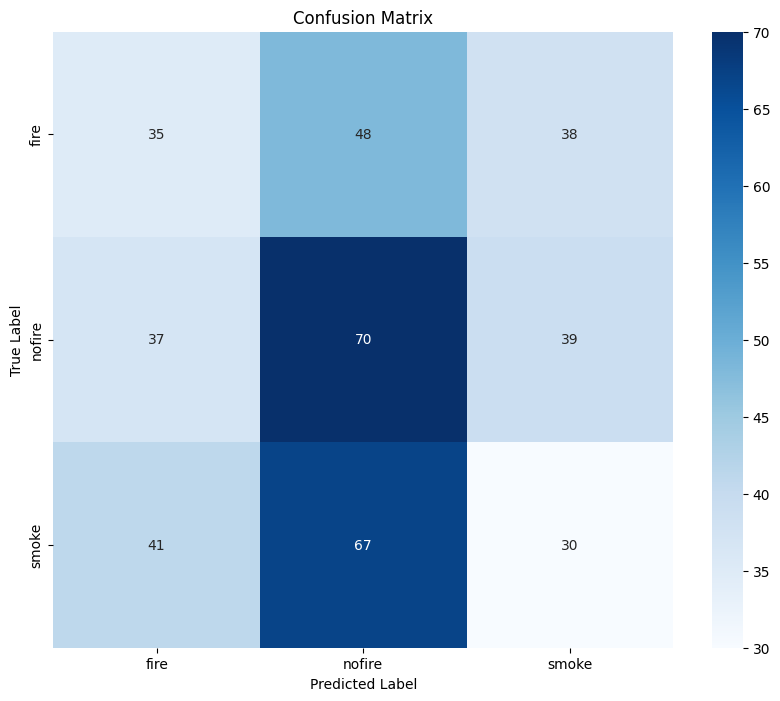

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

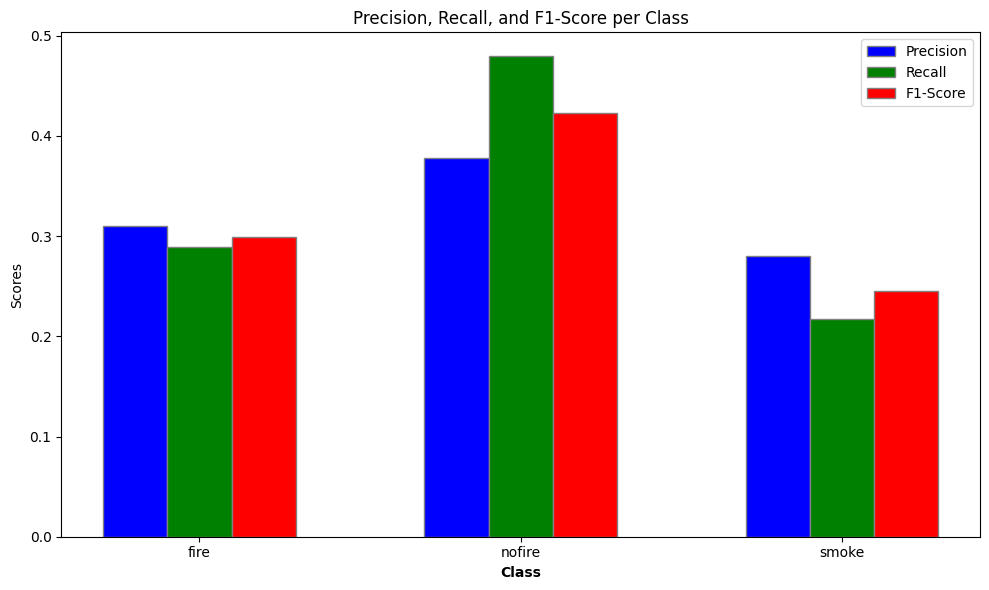

In [17]:
# Get the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Extract precision, recall, and f1-score for each class
precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

# Define bar width
bar_width = 0.2

# Set the positions for the bars
r1 = np.arange(len(class_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the grouped bar plot
plt.figure(figsize=(10, 6))

# Plot precision, recall, and f1-score bars
plt.bar(r1, precision, color='blue', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='green', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='red', width=bar_width, edgecolor='grey', label='F1-Score')

# Add xticks on the middle of the group bars
plt.xlabel('Class', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(class_labels))], class_labels)

# Add labels and title
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score per Class')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

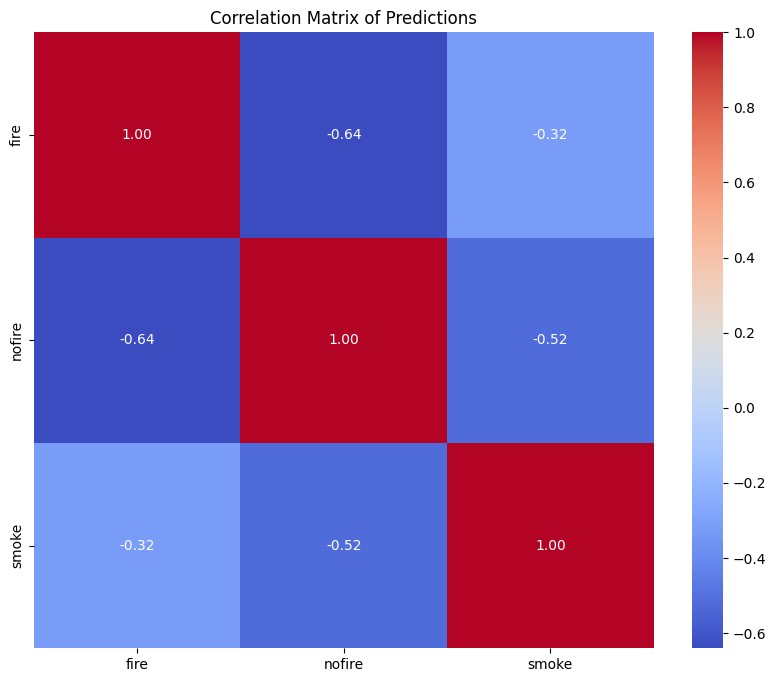

In [18]:
# Compute correlation matrix
correlation_matrix = np.corrcoef(predictions.T)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Correlation Matrix of Predictions')
plt.show()

In [19]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import time

# Load the saved model
saved_model = load_model('forest_fire_classification_model.h5')

# Define categories
categories = ['fire', 'nofire', 'smoke']

# Video file path
video_path = r'Videos\8552246-hd_1920_1080_30fps.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Constants for the input size of the model
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
frame_time = 1.0 / fps  # Time per frame in seconds

# Initialize a dictionary to store the count of each prediction
prediction_counts = {'fire': 0, 'nofire': 0, 'smoke': 0}

# Process the video frame by frame
while cap.isOpened():
    start_time = time.time()  # Start timing the frame processing
    ret, frame = cap.read()  # Read a frame from the video
    if not ret:
        print("End of video.")
        break

    # Preprocess the frame (resize to model input size)
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert OpenCV image to PIL format
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize to match input size (224x224)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction using the loaded model
    predictions = saved_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the predicted label
    label = categories[predicted_class]

    # Update the count of the predicted label
    prediction_counts[label] += 1

    # Optional: Display the frame with the label (you can remove this if you don't want to display each frame)
    cv2.putText(frame, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('Forest Fire Detection', frame)

    # Wait to synchronize with video frame rate
    elapsed_time = time.time() - start_time
    if elapsed_time < frame_time:
        time.sleep(frame_time - elapsed_time)

    # Press 'q' to quit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()

# Determine the final result based on the most frequent prediction
final_prediction = max(prediction_counts, key=prediction_counts.get)

print(f"Final Prediction for the video: {final_prediction}")
print(f"Prediction counts: {prediction_counts}")

1/1 [==============================] - 0s 31ms/step
End of video.
Final Prediction for the video: fire
Prediction counts: {'fire': 244, 'nofire': 0, 'smoke': 53}


In [25]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import time

# Load the saved model
saved_model = load_model('forest_fire_classification_model.h5')

# Define categories
categories = ['fire', 'nofire', 'smoke']

# Video file path
video_path = r'Videos\3069291-hd_1920_1080_30fps.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Constants for the input size of the model
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
frame_time = 1.0 / fps  # Time per frame in seconds

# Initialize a dictionary to store the count of each prediction
prediction_counts = {'fire': 0, 'nofire': 0, 'smoke': 0}

# Process the video frame by frame
while cap.isOpened():
    start_time = time.time()  # Start timing the frame processing
    ret, frame = cap.read()  # Read a frame from the video
    if not ret:
        print("End of video.")
        break

    # Preprocess the frame (resize to model input size)
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert OpenCV image to PIL format
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize to match input size (224x224)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction using the loaded model
    predictions = saved_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the predicted label
    label = categories[predicted_class]

    # Update the count of the predicted label
    prediction_counts[label] += 1

    # Optional: Display the frame with the label (you can remove this if you don't want to display each frame)
    cv2.putText(frame, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('Forest Fire Detection', frame)

    # Wait to synchronize with video frame rate
    elapsed_time = time.time() - start_time
    if elapsed_time < frame_time:
        time.sleep(frame_time - elapsed_time)

    # Press 'q' to quit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()

# Determine the final result based on the most frequent prediction
final_prediction = max(prediction_counts, key=prediction_counts.get)

print(f"Final Prediction for the video: {final_prediction}")
print(f"Prediction counts: {prediction_counts}")

1/1 [==============================] - 0s 34ms/step
End of video.
Final Prediction for the video: smoke
Prediction counts: {'fire': 0, 'nofire': 1, 'smoke': 355}


In [26]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import time

# Load the saved model
saved_model = load_model('forest_fire_classification_model.h5')

# Define categories
categories = ['fire', 'nofire', 'smoke']

# Video file path
video_path = r'Videos\2620570-hd_1280_720_30fps.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Constants for the input size of the model
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
frame_time = 1.0 / fps  # Time per frame in seconds

# Initialize a dictionary to store the count of each prediction
prediction_counts = {'fire': 0, 'nofire': 0, 'smoke': 0}

# Process the video frame by frame
while cap.isOpened():
    start_time = time.time()  # Start timing the frame processing
    ret, frame = cap.read()  # Read a frame from the video
    if not ret:
        print("End of video.")
        break

    # Preprocess the frame (resize to model input size)
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert OpenCV image to PIL format
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize to match input size (224x224)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction using the loaded model
    predictions = saved_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the predicted label
    label = categories[predicted_class]

    # Update the count of the predicted label
    prediction_counts[label] += 1

    # Optional: Display the frame with the label (you can remove this if you don't want to display each frame)
    cv2.putText(frame, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('Forest Fire Detection', frame)

    # Wait to synchronize with video frame rate
    elapsed_time = time.time() - start_time
    if elapsed_time < frame_time:
        time.sleep(frame_time - elapsed_time)

    # Press 'q' to quit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()

# Determine the final result based on the most frequent prediction
final_prediction = max(prediction_counts, key=prediction_counts.get)

print(f"Final Prediction for the video: {final_prediction}")
print(f"Prediction counts: {prediction_counts}")

1/1 [==============================] - 0s 19ms/step
End of video.
Final Prediction for the video: fire
Prediction counts: {'fire': 799, 'nofire': 0, 'smoke': 0}


In [27]:
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import time

# Load the saved model
saved_model = load_model('forest_fire_classification_model.h5')

# Define categories
categories = ['fire', 'nofire', 'smoke']

# Video file path
video_path = r'Videos\1448735-uhd_4096_2160_24fps.mp4'
cap = cv2.VideoCapture(video_path)

# Check if video loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Constants for the input size of the model
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
frame_time = 1.0 / fps  # Time per frame in seconds

# Initialize a dictionary to store the count of each prediction
prediction_counts = {'fire': 0, 'nofire': 0, 'smoke': 0}

# Process the video frame by frame
while cap.isOpened():
    start_time = time.time()  # Start timing the frame processing
    ret, frame = cap.read()  # Read a frame from the video
    if not ret:
        print("End of video.")
        break

    # Preprocess the frame (resize to model input size)
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert OpenCV image to PIL format
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize to match input size (224x224)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction using the loaded model
    predictions = saved_model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the predicted label
    label = categories[predicted_class]

    # Update the count of the predicted label
    prediction_counts[label] += 1

    # Optional: Display the frame with the label (you can remove this if you don't want to display each frame)
    cv2.putText(frame, f'Prediction: {label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow('Forest Fire Detection', frame)

    # Wait to synchronize with video frame rate
    elapsed_time = time.time() - start_time
    if elapsed_time < frame_time:
        time.sleep(frame_time - elapsed_time)

    # Press 'q' to quit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()

# Determine the final result based on the most frequent prediction
final_prediction = max(prediction_counts, key=prediction_counts.get)

print(f"Final Prediction for the video: {final_prediction}")
print(f"Prediction counts: {prediction_counts}")

1/1 [==============================] - 0s 31ms/step
End of video.
Final Prediction for the video: nofire
Prediction counts: {'fire': 42, 'nofire': 717, 'smoke': 0}
